# Study of the distance of the reconstructed barycenter wrt the hottest SiPM

### Notebook configuration

In [1]:
run_number       = 4628
filename_pattern = f"$IC_DATA/Kr/{run_number}/*.h5"

### Imports

In [2]:
import os
import sys
import glob
import collections

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db       as DB
import invisible_cities.io      .pmap_io       as pmpio
import invisible_cities.io      .mchits_io     as mchio
import invisible_cities.core    .fit_functions as fitf
import invisible_cities.core    .exceptions    as excpt
import invisible_cities.reco    .xy_algorithms as XY

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import measurement_string

### Plotting style

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 20

### Load pmaps and database

In [4]:
filenames = glob.glob(os.path.expandvars(filename_pattern))[:10]
DataSiPM  = DB.DataSiPM(run_number)
xy_sipm   = np.stack([DataSiPM.X.values, DataSiPM.Y.values], axis=1)

S1, S2, Si = {}, {}, {}
for filename in filenames:
    s1, s2, si = pmpio.load_pmaps(filename)
    S1.update(s1)
    S2.update(s2)
    Si.update(si)

### Functions

In [5]:
Sensor = collections.namedtuple("Sensor", "ID Q")

def barycenter_Si(si, **corona_opts):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    return XY.corona(xy_sipm[list(IDs)], np.array(Qs), lm_radius=-1, **corona_opts)[0]

def hottest_Si(si):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    hottest = np.argmax(Qs)
    return Sensor(IDs[hottest], Qs[hottest]) 

def get(array, attr):
    return np.array([getattr(x, attr) for x in array])

def plot_si(si, **corona_opts):
    IDs, Qs = zip(*si.sipm_total_energy_dict(0).items())
    Xs , Ys = xy_sipm[list(IDs)].T
    s = plt.scatter(Xs, Ys, c=Qs, marker="s")
    b = barycenter_Si(si, **corona_opts)
    plt.scatter(b.X, b.Y, marker="x", c="r")
    return plt.colorbar(s)

def diff_str(var="x"):
    return f"${var}_b - {var}_h$"#.format(**locals())

def pull_str(var="x"):
    return fr"$\frac{{{var}_b - {var}_h}}{{\sigma_b}}$"

### Event display

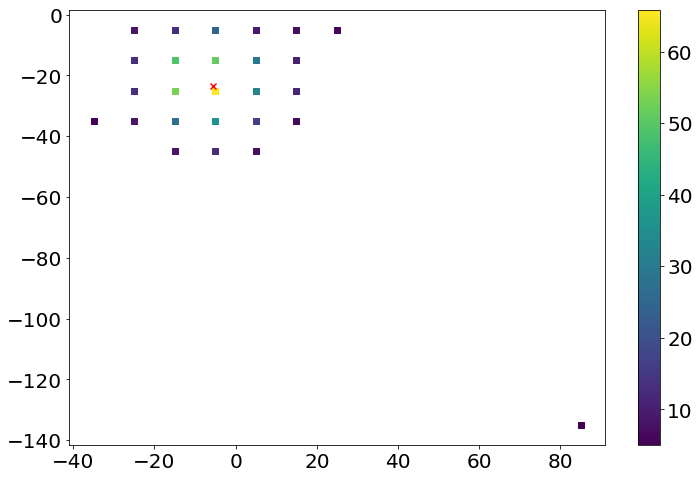

In [6]:
plot_si(next(iter(Si.values())))#, Qthr=20)

### Extract info from pmaps and define variables

In [7]:
datab = []
datah = []

Qthr = 0#30
for evt, si in Si.items():
    try:
        datab.append(barycenter_Si(si, Qthr=Qthr))
        datah.append(   hottest_Si(si))
    except (KeyError, excpt.SipmEmptyListAboveQthr):
        pass

In [8]:
Xb = get(datab, "X")
Yb = get(datab, "Y")
Qb = get(datab, "Q")
Nb = get(datab, "nsipm")

IDh = get(datah, "ID")
Qh  = get(datah, "Q" )
Xh,\
Yh  = xy_sipm[IDh].T

Xrms = get(datab, "Xrms")
Yrms = get(datab, "Yrms")

sXb = Xrms / Nb**0.5
sYb = Yrms / Nb**0.5

Rb = (Xb**2 + Yb**2)**0.5

In [9]:
diff_x = Xb - Xh
pull_x = diff_x  / sXb
diff_y = Yb - Yh
pull_y = diff_y  / sYb

# Plots

### Charge

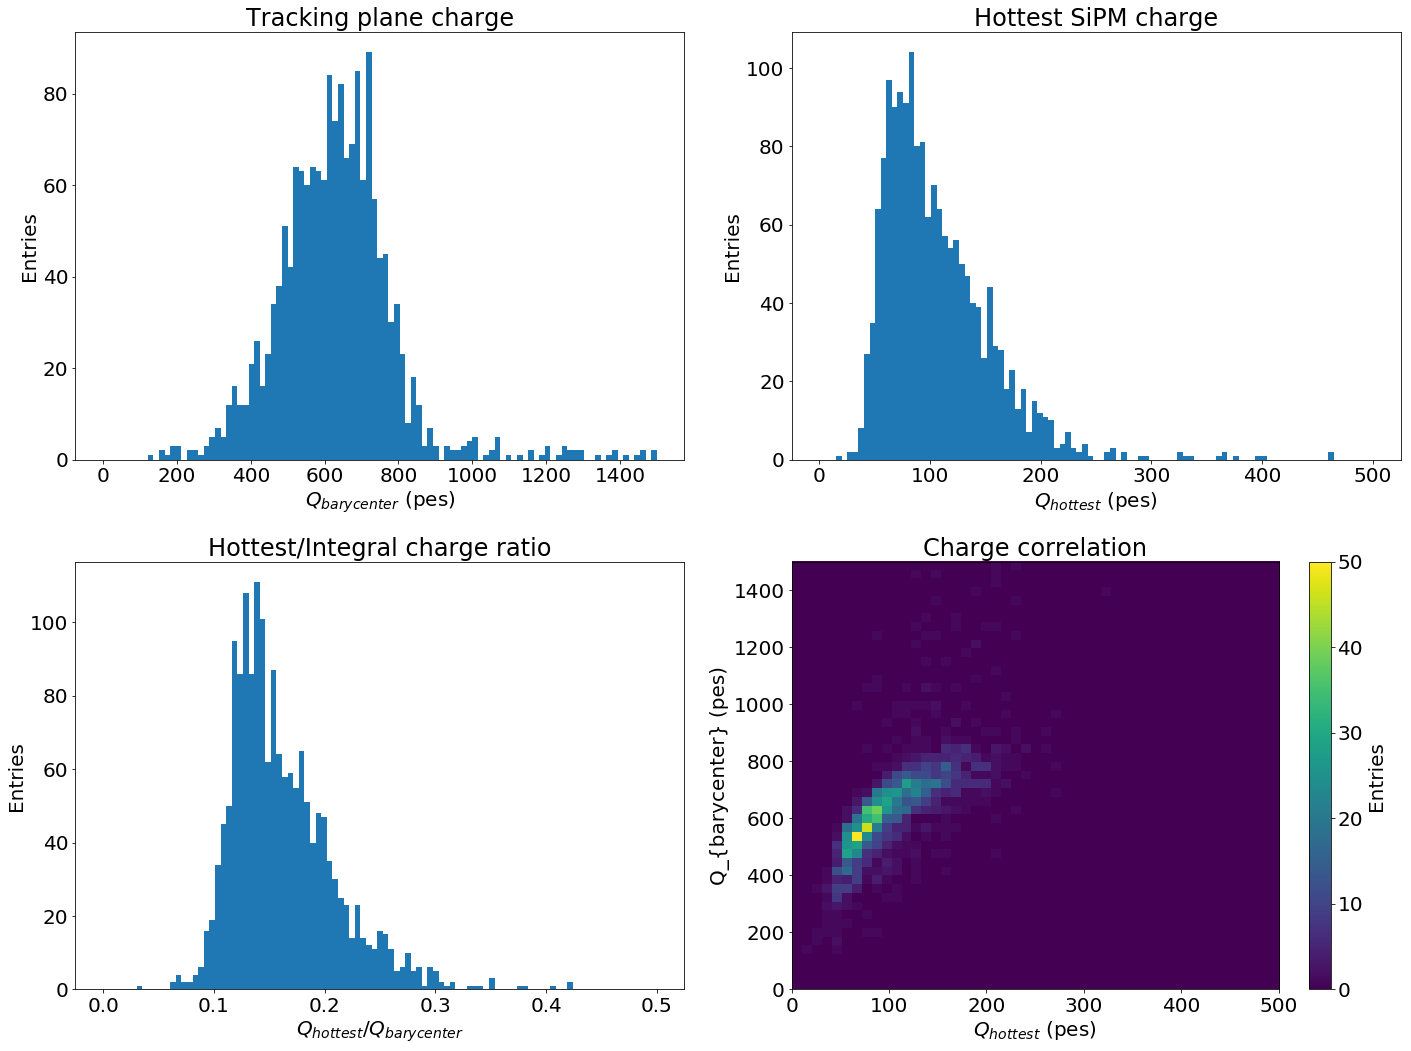

In [10]:
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
hist(Qb, np.linspace(0, 1500, 100), new_figure=False)
labels("$Q_{barycenter}$ (pes)", "Entries", "Tracking plane charge")

plt.subplot(2, 2, 2)
hist(Qh, np.linspace(0,  500, 100), new_figure=False)
labels("$Q_{hottest}$ (pes)", "Entries", "Hottest SiPM charge")

plt.subplot(2, 2, 3)
hist(Qh/Qb, np.linspace(0, 0.5, 100), new_figure=False)
labels("$Q_{hottest}$/$Q_{barycenter}$", "Entries", "Hottest/Integral charge ratio")

plt.subplot(2, 2, 4)
hist2d(Qh, Qb, [np.linspace(0,  500, 50),
                np.linspace(0, 1500, 50)], new_figure=False)
plt.colorbar().set_label("Entries")
labels("$Q_{hottest}$ (pes)", "Q_{barycenter} (pes)", "Charge correlation")

plt.tight_layout()

### Reconstruction output

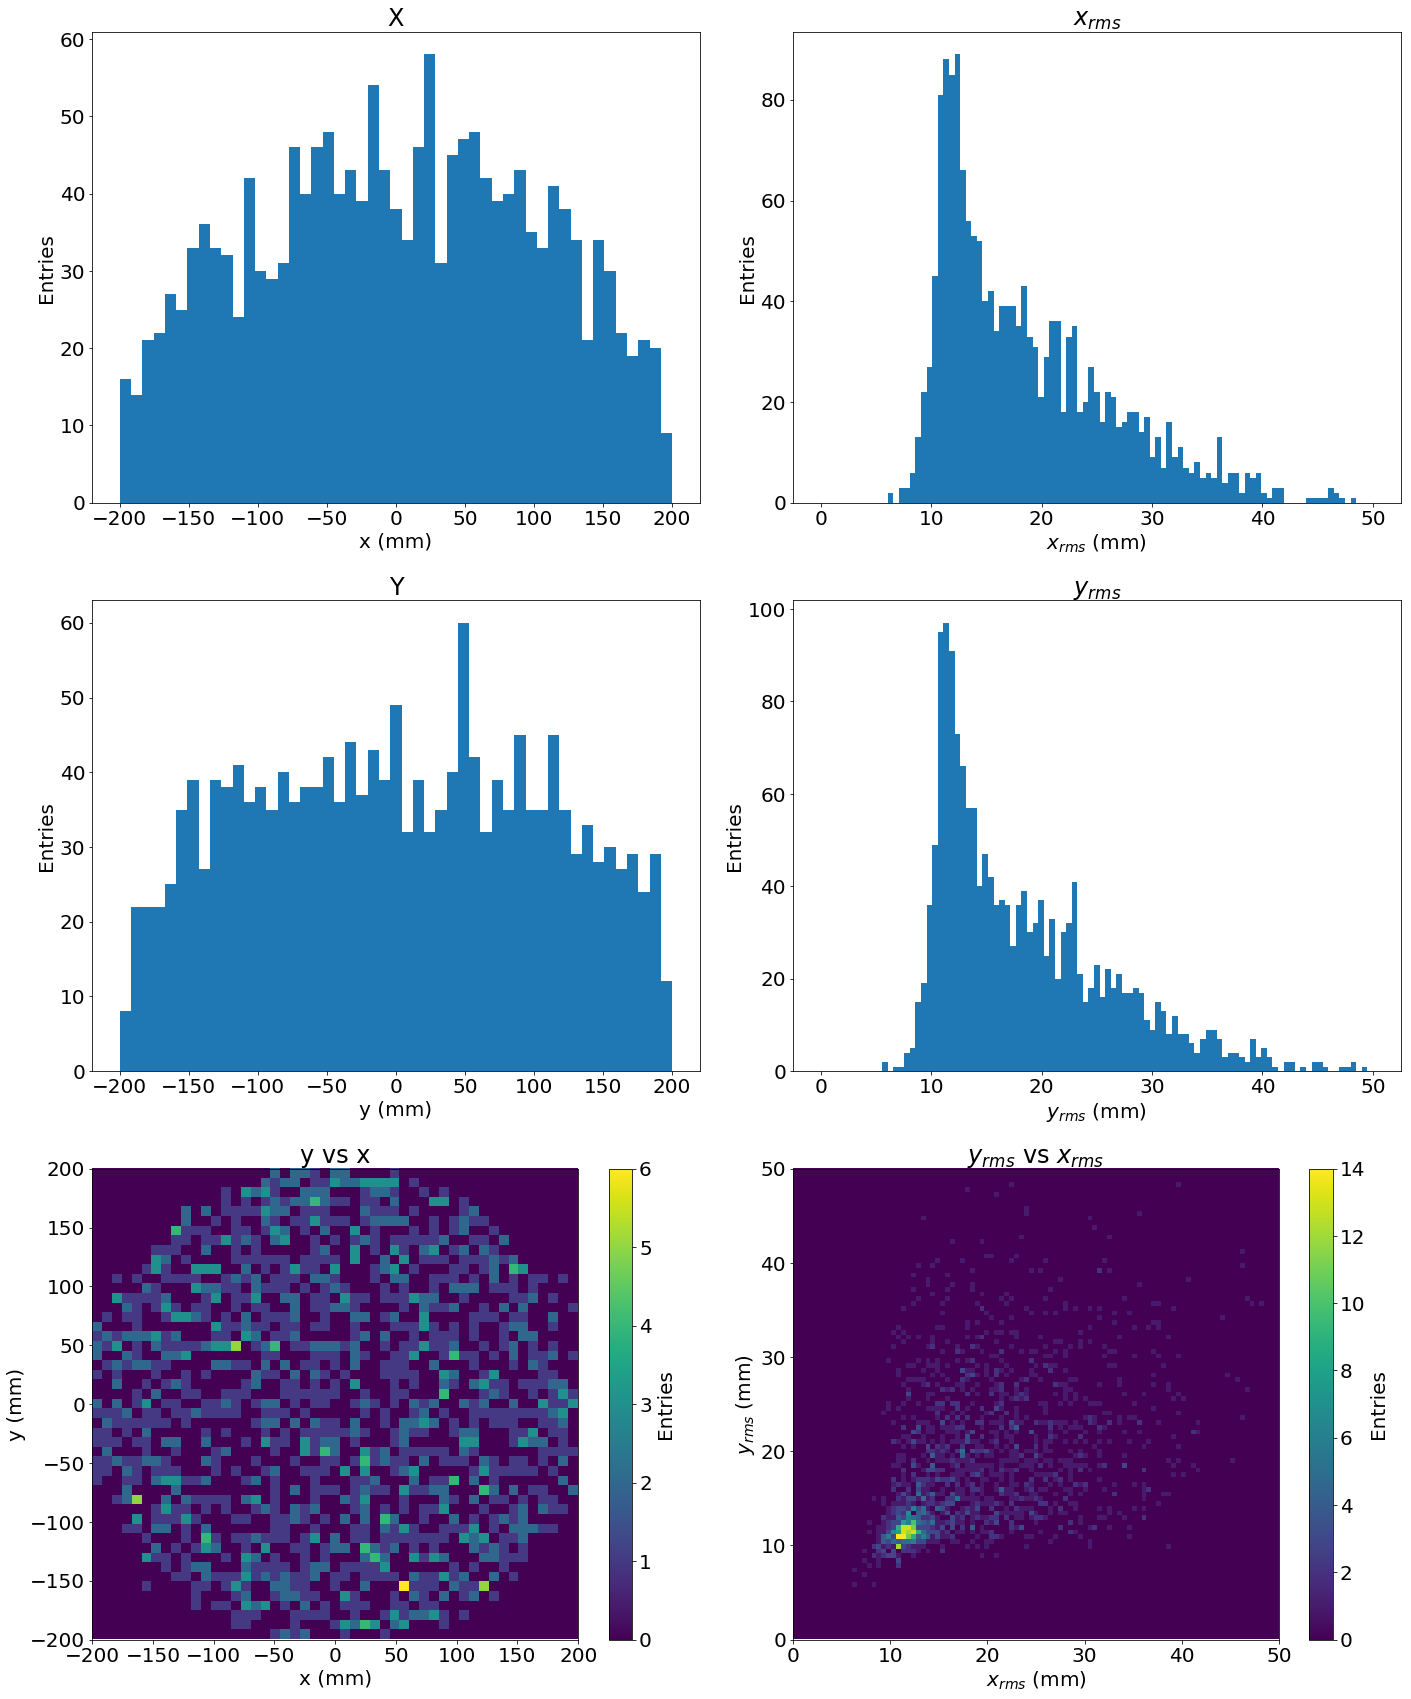

In [11]:
plt.figure(figsize=(20, 24))

plt.subplot(3, 2, 1)
y, x, _ = hist(Xb, np.linspace(-200, 200, 50), new_figure=False)
labels("x (mm)", "Entries", "X")

plt.subplot(3, 2, 3)
y, x, _ = hist(Yb, np.linspace(-200, 200, 50), new_figure=False)
labels("y (mm)", "Entries", "Y")

plt.subplot(3, 2, 5)
hist2d(Xb, Yb, (np.linspace(-200, 200, 50),
                np.linspace(-200, 200, 50)), new_figure=False)
plt.colorbar().set_label("Entries")
labels("x (mm)", "y (mm)", "y vs x")

plt.subplot(3, 2, 2)
y, x, _ = hist(Xrms, np.linspace(0, 50, 100), new_figure=False)
labels("$x_{rms}$ (mm)", "Entries", "$x_{rms}$")

plt.subplot(3, 2, 4)
y, x, _ = hist(Yrms, np.linspace(0, 50, 100), new_figure=False)
labels("$y_{rms}$ (mm)", "Entries", "$y_{rms}$")

plt.subplot(3, 2, 6)
hist2d(Xrms, Yrms, (np.linspace(0, 50, 100),
                    np.linspace(0, 50, 100)), new_figure=False)
plt.colorbar().set_label("Entries")
labels("$x_{rms}$ (mm)", "$y_{rms}$ (mm)", "$y_{rms}$ vs $x_{rms}$")

plt.tight_layout()

### Distances

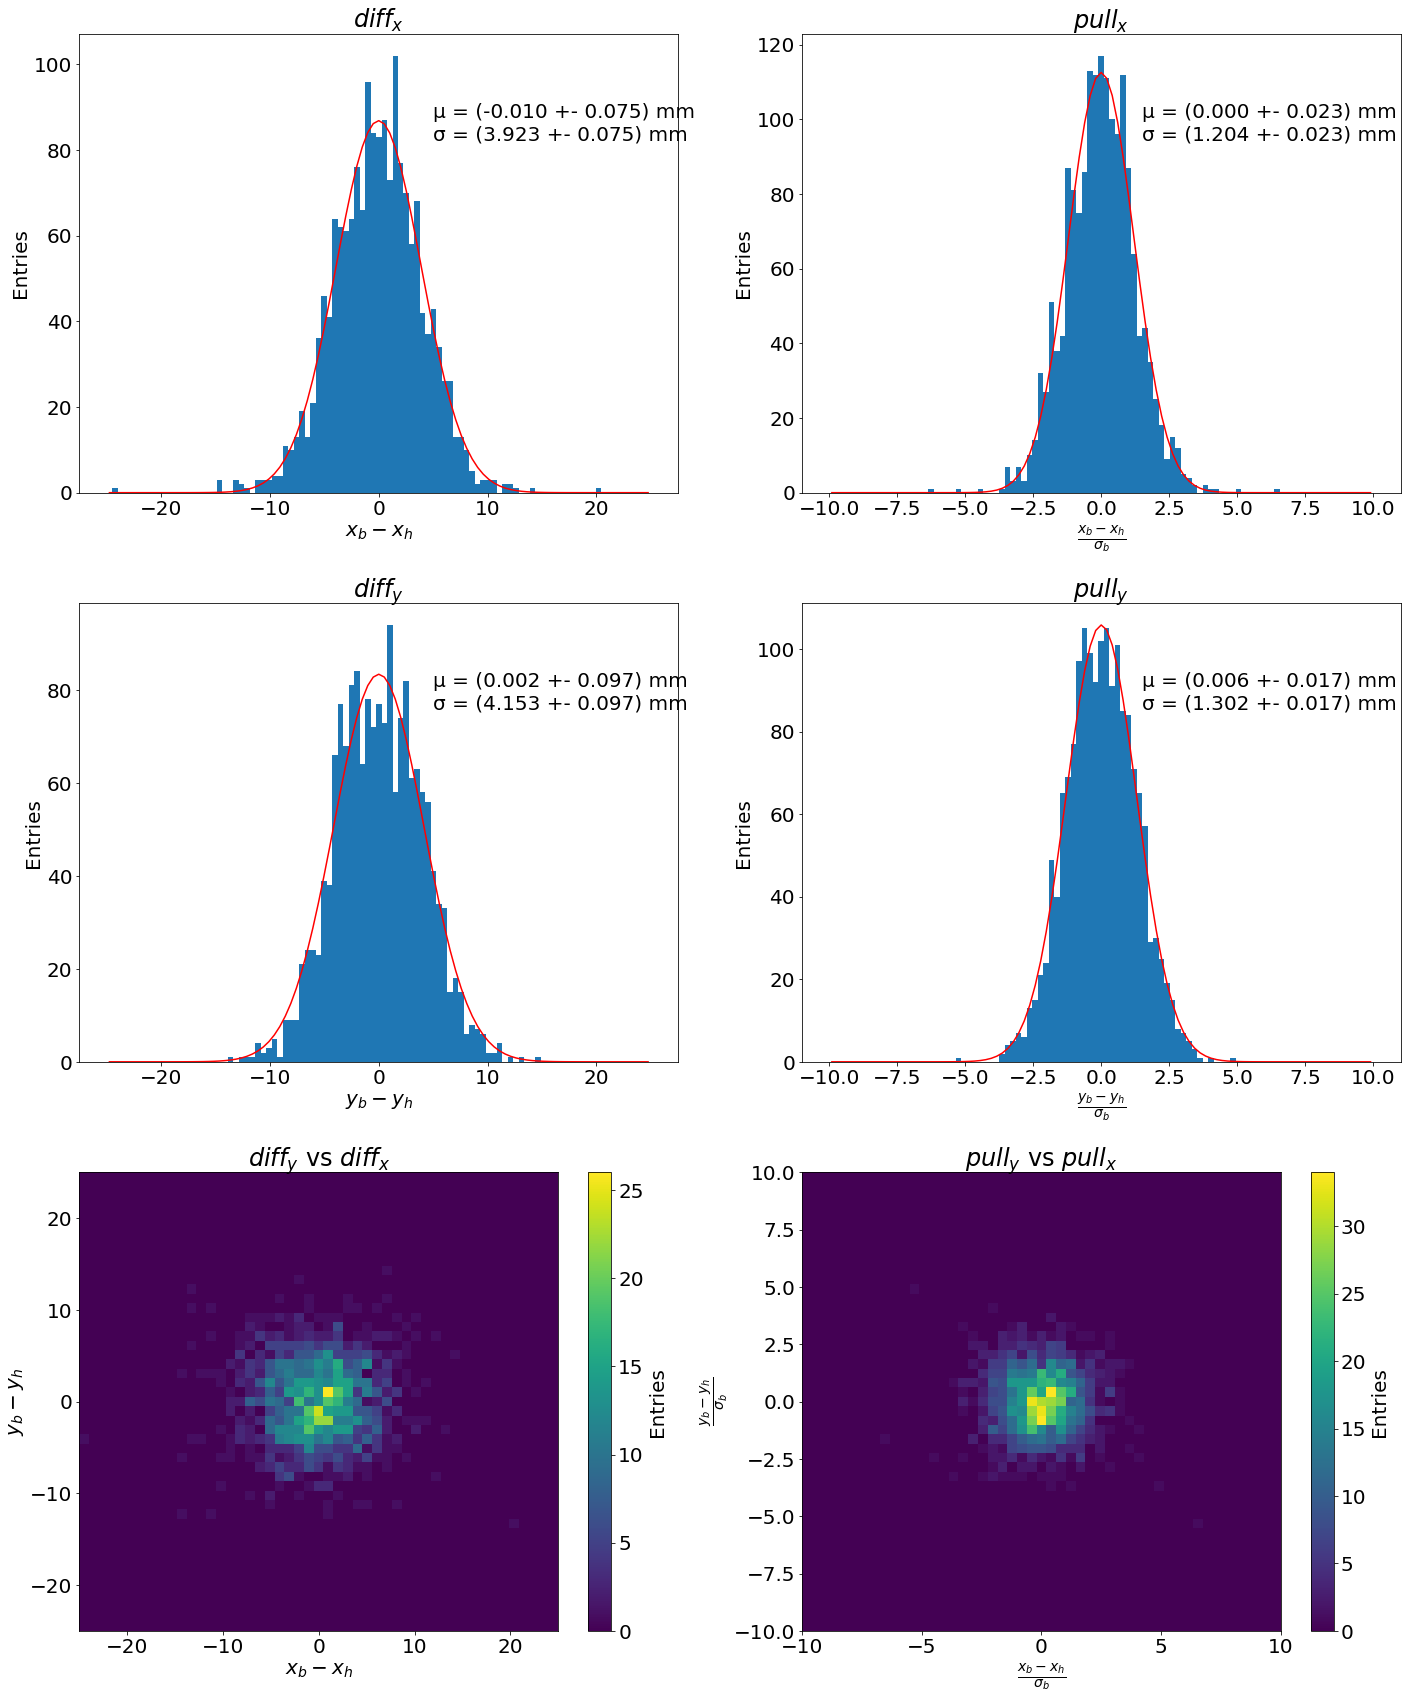

In [12]:
plt.figure(figsize=(20, 24))

plt.subplot(3, 2, 1)
y, x, _ = hist(diff_x, np.linspace(-25, 25, 100), new_figure=False)
f       = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                 measurement_string(f.values[2], f.errors[2])))
labels(diff_str("x"), "Entries", "$diff_x$")

plt.subplot(3, 2, 3)
y, x, _ = hist(diff_y, np.linspace(-25, 25, 100), new_figure=False)
f       = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                 measurement_string(f.values[2], f.errors[2])))
labels(diff_str("y"), "Entries", "$diff_y$")

plt.subplot(3, 2, 5)
hist2d(diff_x, diff_y, (np.linspace(-25, 25, 50),
                        np.linspace(-25, 25, 50)), new_figure=False)
plt.colorbar().set_label("Entries")
labels(diff_str("x"), diff_str("y"), "$diff_y$ vs $diff_x$")

plt.subplot(3, 2, 2)
y, x, _ = hist(pull_x, np.linspace(-10, 10, 100), new_figure=False)
f       = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(1.5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                   measurement_string(f.values[2], f.errors[2])))
labels(pull_str("x"), "Entries", "$pull_x$")

plt.subplot(3, 2, 4)
y, x, _ = hist(pull_y, np.linspace(-10, 10, 100), new_figure=False)
f       = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(1.5, plt.ylim()[1]/1.3, "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                                                   measurement_string(f.values[2], f.errors[2])))
labels(pull_str("y"), "Entries", "$pull_y$")

plt.subplot(3, 2, 6)
hist2d(pull_x, pull_y, (np.linspace(-10, 10, 50),
                        np.linspace(-10, 10, 50)), new_figure=False)
plt.colorbar().set_label("Entries")
labels(pull_str("x"), pull_str("y"), "$pull_y$ vs $pull_x$")

plt.tight_layout()

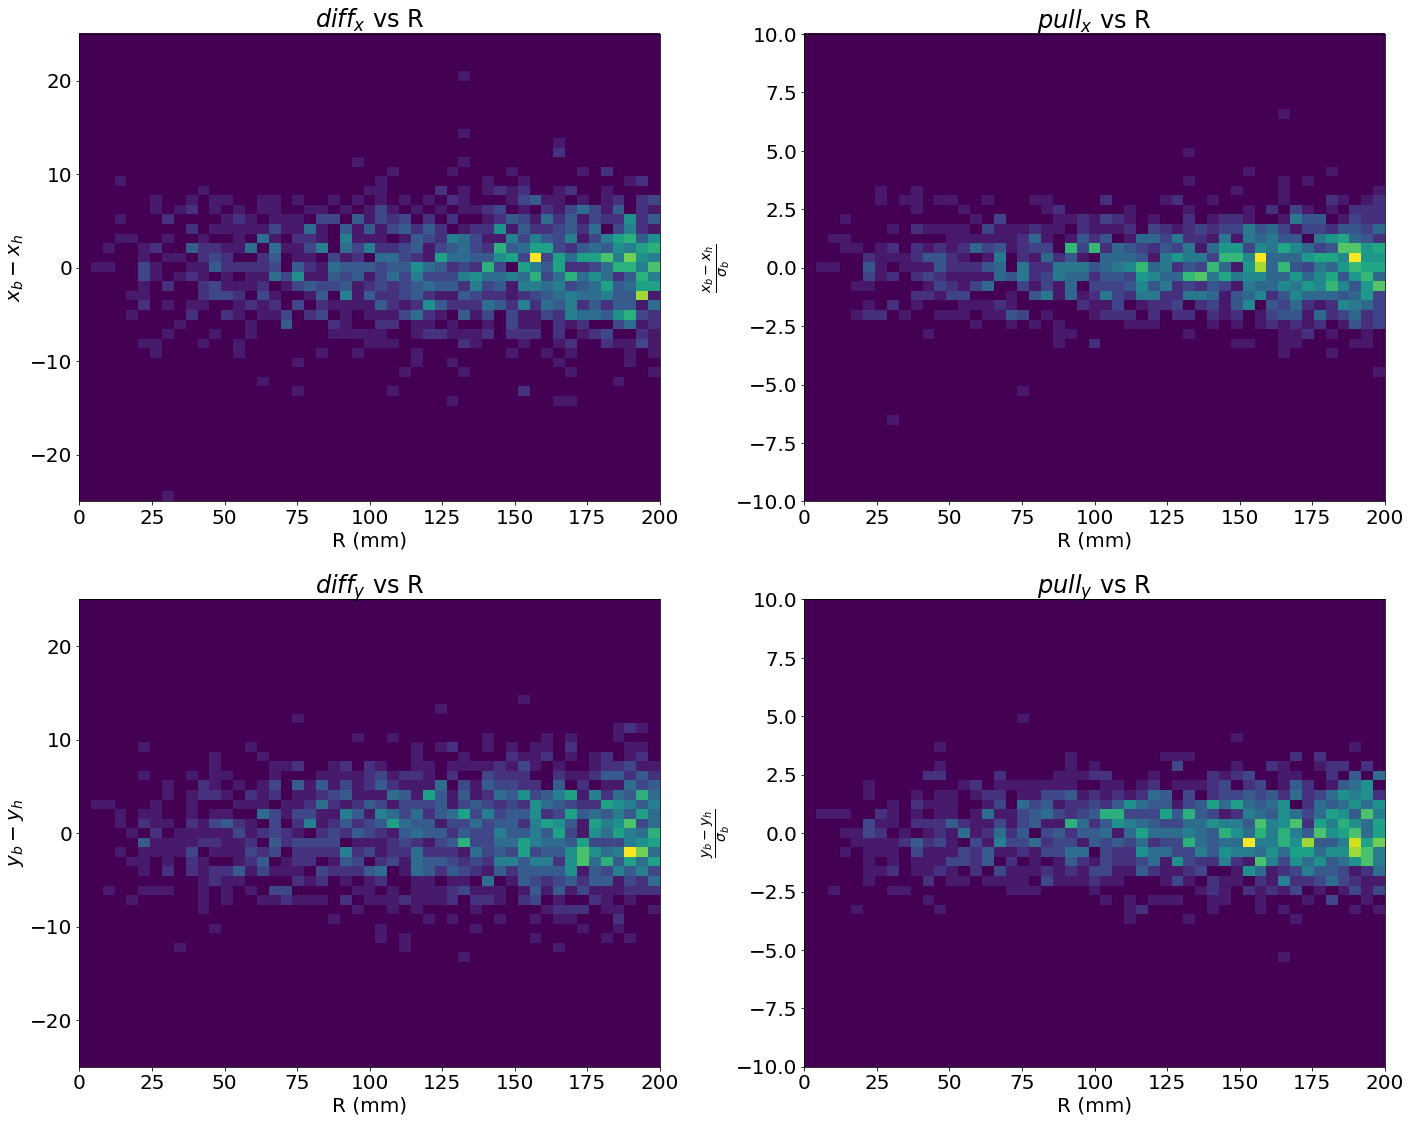

In [13]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
z, x, y, _ = hist2d(Rb, diff_x, (np.linspace(  0, 200, 50),
                                 np.linspace(-25,  25, 50)), new_figure=False)
labels("R (mm)", diff_str("x"), "$diff_x$ vs R")

plt.subplot(2, 2, 3)
z, x, y, _ = hist2d(Rb, diff_y, (np.linspace(  0, 200, 50),
                                 np.linspace(-25,  25, 50)), new_figure=False)
labels("R (mm)", diff_str("y"), "$diff_y$ vs R")

plt.subplot(2, 2, 2)
z, x, y, _ = hist2d(Rb, pull_x, (np.linspace(  0, 200, 50),
                                 np.linspace(-10,  10, 50)), new_figure=False)
labels("R (mm)", pull_str("x"), "$pull_x$ vs R")

plt.subplot(2, 2, 4)
z, x, y, _ = hist2d(Rb, pull_y, (np.linspace(  0, 200, 50),
                                 np.linspace(-10,  10, 50)), new_figure=False)
labels("R (mm)", pull_str("y"), "$pull_y$ vs R")

plt.tight_layout()

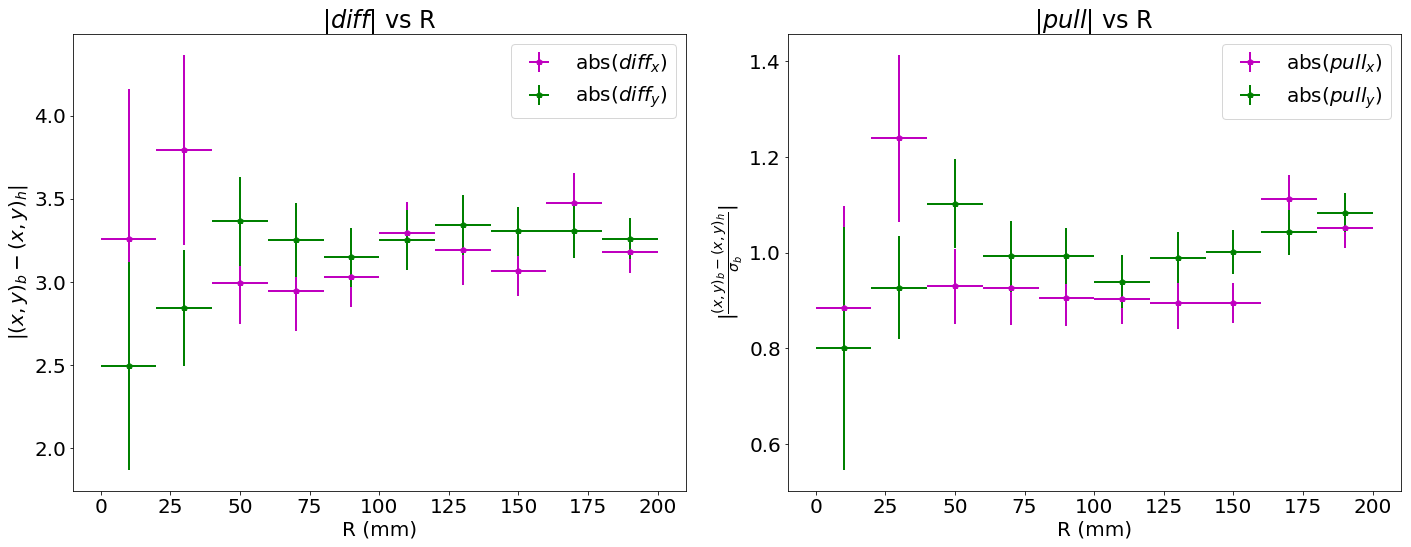

In [14]:
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
r, x, u_x = fitf.profileX(Rb, np.abs(diff_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rb, np.abs(diff_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($diff_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($diff_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(diff_str("(x,y)")), "|$diff$| vs R")

plt.subplot(1, 2, 2)
r, x, u_x = fitf.profileX(Rb, np.abs(pull_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rb, np.abs(pull_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($pull_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($pull_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(pull_str("(x,y)")), "|$pull$| vs R")

plt.tight_layout()

[  7.63458309e+02  -6.77840850e-03   1.00072977e+00]
0.0019


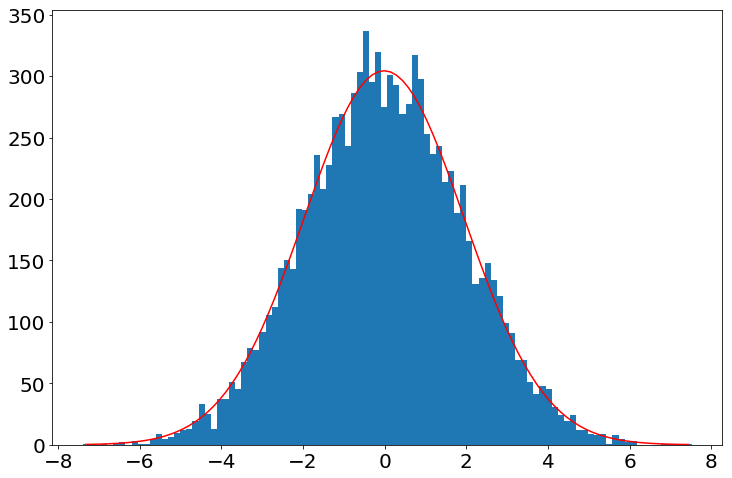

In [78]:
N = 10000
n = 869
d = 100
a = np.array([np.random.uniform(-d, d, size=n) for i in range(N)])
m = np.mean(a, axis=1)
s = np.std (a, axis=1)
y, x, _ = hist(m, 100);
f = fitf.fit(fitf.gauss, x, y, (1, 0, 1))
plt.plot(x, f.fn(x), "r")
sigma = d/n**0.5/3**0.5
print(f.values/sigma)
print(np.count_nonzero(abs(m)>3*sigma)/N)

In [34]:
np.count_nonzero(np.abs(a) > (1/3**0.5))/1e4

0.7648

In [35]:
1/3**0.5

0.5773502691896258